In [1]:
import gpytorch
import numpy as np

from bo_functions import best_error_advanced
from bo_functions import calc_ei_advanced
from bo_functions import LHS_Design
from bo_functions import create_y_data
from bo_functions import test_train_split
from bo_functions import ExactGPModel
from bo_functions import train_GP_model
from bo_functions import calc_GP_outputs
from bo_functions import calc_y_expected
from bo_functions import improvement_integral
from bo_functions import improvement_int_terms

from bo_plotters import plotter_adv
from bo_plotters import y_plotter_adv
from bo_plotters import stdev_plotter_adv
from bo_plotters import error_plotter_adv
from bo_plotters import ei_plotter_adv
from bo_plotters import improvement_integral_plot
from bo_plotters import improvement_int_terms_plot

In [2]:
#Set noise parameters and load csv file to generate training data
noise_std = 0.1**2
all_p = LHS_Design("LHS_Toy_3_Input.csv")
all_y = create_y_data(all_p, noise_std)

#Separate training and testing data, uses default of an 80%/20% split
train_test_data = test_train_split(all_p,all_y)

train_p = train_test_data[0] #1x19
train_y = train_test_data[1] #1x19
test_p = train_test_data[2] #1x19
test_y = train_test_data[3] #1x19
print(test_p)

tensor([[ 1.6023, -0.3062,  1.9780],
        [ 1.3769, -0.4788, -1.4939],
        [ 0.2180, -1.6312, -1.0622],
        [ 1.7776, -1.8356, -1.6141],
        [ 0.4116, -1.0924,  0.0214],
        [-0.8668,  1.2260, -1.0091]], dtype=torch.float64)


In [3]:
# initialize likelihood and model
##Assumes a homoskedastic noise model p(y | f) = f + noise
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# We will use the simplest form of GP model, exact inference
#Defines our model in terms of the class parameters in bo_functions
model = ExactGPModel(train_p, train_y, likelihood)

In [4]:
#Set number of training iterations and train GP
iterations = 500
train_GP_model(model,likelihood, train_p, train_y, iterations)

In [5]:
# Get into evaluation (predictive posterior) mode
#Puts model in evaluation mode
model.eval()
#Puts likelihood in evaluation mode
likelihood.eval();

In [6]:
#Create Meshgrid
point_num = 4
test_p1 = np.linspace(-2,2,point_num) #Any bigger than 4 and the kernel just dies
test_p2 = np.linspace(-2,2,point_num)
test_p3 = np.linspace(-2,2,point_num)

# test_p1 = np.arange(-2,2,0.5) #Theta 1 
# test_p2 = np.arange(-2,2,0.5) #Theta 2
# test_p3 = np.arange(-2,2,0.5) #Theta 3

test_p_mesh = np.array(np.meshgrid(test_p1,test_p2,test_p3))
# print(test_p_mesh)

test_p_mesh_plot = test_p_mesh.T.reshape(-1,3)
# print(test_p_mesh_plot)

In [7]:
#Calculates GP outputs for mean, variance, standard devaition, and y output
GP_Outputs = calc_GP_outputs(model,likelihood,test_p_mesh_plot)

model_mean = GP_Outputs[0] #1x6
model_variance= GP_Outputs[1] #1x6
model_stdev = GP_Outputs[2] #1x6
model_y = GP_Outputs[3] #1x6

#Calculates expected y
y_exp = calc_y_expected(test_p_mesh_plot, noise_std) #1x6

# print("Model Mean \n", model_mean)
# print("Model Variance \n", model_variance)
# print("Model Standard Deviation \n", model_stdev)
# print("Model y \n", model_y)
# print("Y Value Expected \n", y_exp)

In [8]:
#Calculates best_error and expected improvement
best_error = best_error_advanced(model_y, y_exp)[0] #Scaler
best_x = best_error_advanced(model_y, y_exp)[1] #1x3
# print("best x",best_x)
# print(test_p[1])
ei = calc_ei_advanced(best_error,model_mean,model_variance, y_exp) #1x6
# print("Best Error is: ",best_error)
# print("EI:",ei)
# argmax_ei = np.argmax(ei)
# print("argmax is", argmax_ei)
# print("The test parameter set that gives the highest expected imrovement is \nTheta1, Theta2, x = \n")
# print(test_p_mesh_plot[argmax_ei])

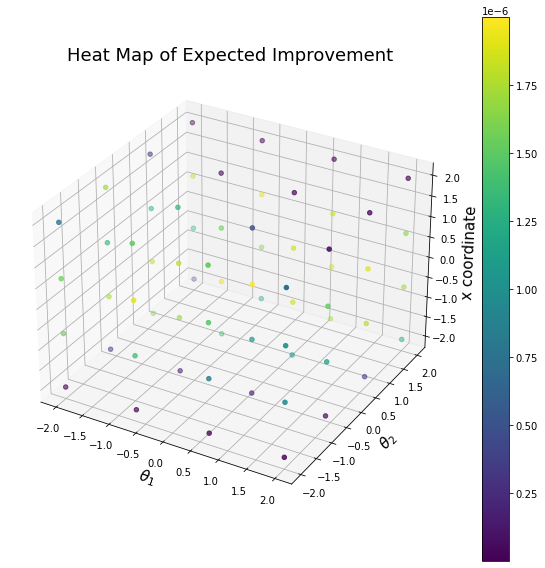

None


In [9]:
print(ei_plotter_adv(test_p_mesh_plot, ei))

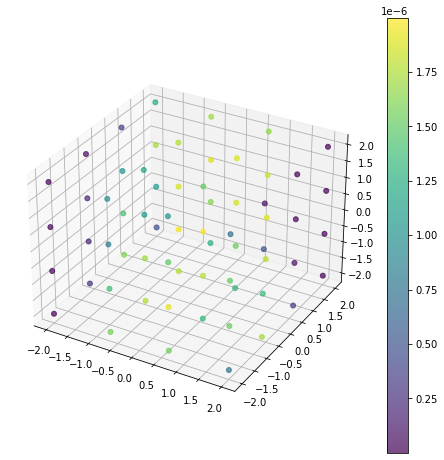

In [10]:
# only for example, use your grid
import matplotlib.pyplot as plt

X, Y, Z = np.meshgrid(test_p1, test_p2, test_p3)

# Your 4dimension, only for example use yours
ei = ei.reshape(-1,point_num).T

# Creating figure
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection="3d")

# Creating plot
img = ax.scatter3D(X, Y, Z, c=ei, alpha=0.7,s=100, marker='.', cmap = plt.viridis())
fig.colorbar(img)
plt.show()